# Homework 1 by Ryan Beam

### Prep: Setup and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('T_F41SCHEDULE_B43.zip')
data.info()

<ipython-input-2-dc8e64964a68>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('T_F41SCHEDULE_B43.zip')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

In [3]:
# Note: comments with (CAI) can be assumed to be for the explicit purpose of promting
# the Colab AI complete and to have generated the succeeding few lines of code

### 1. Missing data part one

Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.

Columns for investigation:
CARRIER, CARRIER_NAME, MANUFACTURE_YEAR, NUMBER_OF_SEATS, CAPACITY_IN_POUNDS, and AIRLINE_ID.

For example, watch out for "North American Airlines" aircrafts. Are the CARRIER/UNIQUE_CARRIER column really missing?

In [4]:
cols_i = [
    'CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
    'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID'
    ]

# (CAI) Print the column name and number of null rows for each column in cols_i
for col in cols_i:
    print(f"{col+':':20}", data[col].isnull().sum())

CARRIER:             49
CARRIER_NAME:        105
MANUFACTURE_YEAR:    3
NUMBER_OF_SEATS:     7
CAPACITY_IN_POUNDS:  101
AIRLINE_ID:          105


In [5]:
# Carrier
data[data['CARRIER'].isnull()]['CARRIER_NAME'].value_counts()

,count
CARRIER_NAME,
North American Airlines,49


In [6]:
# North American Airlines has IATA code NA, which is read as NaN by pandas
# (CAI) Set all null values in column CARRIER to "NA"
data['CARRIER'] = data['CARRIER'].fillna('NA')

In [7]:
# North American Airlines fleet
data[data['CARRIER'] == 'NA']['MODEL'].value_counts()

,count
MODEL,
B767-3,10
B757-2,10
B767-300PSGR,10
B-767-3,5
B-757-2,5
B-767-300PAX,5
B757-200PSGR,4


Looking at the fleet here, we can already see that the MODEL column will be a headache to deal with. I am curious whether PAX vs PSGR (obviously both mean passenger) is a time entry symptom of changing convention or is related to B767-300 LR vs ER models, which are not specified here.

In [8]:
# Carrier Name
print(data[data['CARRIER_NAME'].isnull()]['CARRIER'].unique())
data[data['CARRIER_NAME'].isnull()]['CARRIER'].value_counts()

['L4' 'OH']


,count
CARRIER,
OH,97
L4,8


A little [research](https://www.iata.org/en/publications/directories/code-search/) finds that these IATA codes are for PSA Airlines (OH) and The Landline Company (L4). PSA Airlines is one of the few regional carriers in the US that flies under the American Eagle brand, which can get convoluted.

In [9]:
# Search for 'American Eagle' in CARRIER_NAME
data[data['CARRIER_NAME'].notna() & data['CARRIER_NAME'].str.contains('American Eagle')]['CARRIER'].value_counts()

,count
CARRIER,
MQ,1838
MQ,287


Wondering if the strings need to be stripped. Will do so when no more null data.

In [10]:
data[data['CARRIER_NAME'].notna() & data['CARRIER_NAME'].str.contains('American Eagle')]['CARRIER'].unique()

array(['MQ', 'MQ '], dtype=object)

In [11]:
# (CAI) Search CARRIER for strings containing "PT","MQ","OH","YX", and "OO"
data[data['CARRIER'].str.contains('PT|MQ|OH|YX|OO')][['CARRIER','CARRIER_NAME']].value_counts()

CARRIER  CARRIER_NAME                
OO       SkyWest Airlines Inc.           6847
MQ       Envoy Air                       1990
         American Eagle Airlines Inc.    1838
YX       Republic Airline                1271
OH       PSA Airlines Inc.               1176
YX       Republic Airlines                814
OH       Comair Inc.                      623
OO       SkyWest Airlines Inc.            292
MQ       American Eagle Airlines Inc.     287
PT       Piedmont Airlines                204
OH       Comair Inc.                      114
AMQ      Ameristar Air Cargo               98
YX       Midwest Airline, Inc.             93
YX       Republic Airlines                 85
PT       Capital Cargo International       75
PT       Capital Cargo International       16
Name: count, dtype: int64

I will match the OH Carrier Name nulls with the rest of the OHs as PSA Airlines.

In [12]:
# (CAI) Set CARRIER_NAME to "PSA Airlines Inc." in rows where it is null and CARRIER is "OH"
data.loc[(data['CARRIER_NAME'].isnull()) & (data['CARRIER'] == 'OH'), 'CARRIER_NAME'] = 'PSA Airlines Inc.'
data[data['CARRIER_NAME'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
11465,2007,L4,NaN,2007.0,NaN,4165,N501LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,7/19/2007 12:00:00 AM,NaN,NaN
11466,2007,L4,NaN,2007.0,NaN,4168,N502LX,O,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,8/28/2007 12:00:00 AM,NaN,NaN
11467,2007,L4,NaN,2007.0,NaN,4170,N503LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/12/2007 12:00:00 AM,NaN,NaN
11468,2007,L4,NaN,2007.0,NaN,4172,N504LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/19/2007 12:00:00 AM,NaN,NaN
11469,2007,L4,NaN,2007.0,NaN,4174,N505LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/25/2007 12:00:00 AM,NaN,NaN
11470,2007,L4,NaN,2007.0,NaN,4176,N506LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/31/2007 12:00:00 AM,NaN,NaN
11471,2007,L4,NaN,2007.0,NaN,4181,N507LX,O,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,12/31/2007 12:00:00 AM,NaN,NaN
11472,2007,L4,NaN,2007.0,NaN,4182,N508LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,12/31/2007 12:00:00 AM,NaN,NaN


In [13]:
print(data[data['CARRIER_NAME'].isnull()]['MODEL'].value_counts())
data[data['CARRIER'] == 'L4'][['MODEL','CARRIER_NAME']].value_counts()

MODEL
DASH8-Q4    8
Name: count, dtype: int64


,,count
MODEL,CARRIER_NAME,
DASH8-Q4,Lynx Aviation d/b/a Frontier Airlines,10


When I google Lynx Aviation, I find that this was a regional airline that ceased operations, and has the IATA code of L3. I wonder if this is a typo, considering that The Landline Company (L4) is a bus company. LASA Airlines was a startup in South America from 2017 that appears to have used L4, but it did not have any Dash-8 aircraft, only Embraer aircraft in its fleet according to Wikipedia.

In [14]:
# (CAI) Find value counts for CARRIER containing "L3"
data[data['CARRIER'].str.contains('L3|L4')][['CARRIER','CARRIER_NAME','AIRLINE_ID']].value_counts()

,,,count
CARRIER,CARRIER_NAME,AIRLINE_ID,
L3,Lynx Aviation d/b/a Frontier Airlines,21217.0,11
L4,Lynx Aviation d/b/a Frontier Airlines,21217.0,10
L3,Lynx Aviation d/b/a Frontier Airlines,21217.0,6


I think the most logical solution is to input Lynx Aviation as the name here, as perhaps there was a data entry problem. This is confirmed by investigating the tail number of one of these aircraft [here](https://www.flightradar24.com/data/aircraft/n501lx).

In [15]:
# (CAI) Set null values of carrier name where Carrier contains "L4" to "Lynx Aviation d/b/a Frontier Airlines"
data.loc[(data['CARRIER_NAME'].isnull()) & (data['CARRIER'].str.contains('L4')), 'CARRIER_NAME'] = 'Lynx Aviation d/b/a Frontier Airlines'

In [16]:
# Manufacture Year
data[data['MANUFACTURE_YEAR'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y
124680,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10134,N655CA,O,Y,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E
124681,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10182,N690CA,O,N,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E


I've confirmed the age of the three jets by looking up their tail numbers.

In [17]:
tails = {'N655CA': 2004, 'N690CA': 2004}
data.loc[data['MANUFACTURE_YEAR'].isnull(), 'MANUFACTURE_YEAR'] = data['TAIL_NUMBER'].map(tails)

In [18]:
data[data['MANUFACTURE_YEAR'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y


After looking into this aircraft, I've found it's a B767-300ER which is not the 747 model listed at all. The age of the plane is 31 years.

In [19]:
data[data['AIRCRAFT_TYPE'] == 8192]['MODEL'].value_counts()

,count
MODEL,
B747-400,192
747-44AF,74
747-400M,42
747-446,35
747-45E,23
747-428BCF,18
747-4H6,16
747-4B5F,16
747-481F,11


In [20]:
data[data['TAIL_NUMBER'] == 'N664GT']

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y


In [21]:
data[(data['CARRIER_NAME'].str.contains('Atlas Air Inc.')) & (data['YEAR'] >= 2021)][['YEAR','MODEL','AIRCRAFT_TYPE']].value_counts()

YEAR  MODEL        AIRCRAFT_TYPE
2022  B747-400     8192             42
2023  B747-400     8192             38
2022  B767-300ER   6261             25
2023  B767-300ER   6262             20
      B747-800     8212             14
2022  B747-800     8212             13
      B777-200     6272              9
2023  B737-800     6142              7
2022  B737-800     6142              7
2023  B767-300ER   6261              5
      B747-400     8191              5
      777FZB       6272              4
      B777-200     6272              3
2022  B747-400     8191              2
2023  777F16       6272              2
2022  B747-400BCF  8192              1
      B737-800     6272              1
2023  777F1H       6272              1
      777F         6272              1
      B747-400BCF  8192              1
      B737-800     6272              1
Name: count, dtype: int64

In [22]:
data.loc[data['TAIL_NUMBER'] == 'N664GT', 'MODEL'] = 'B767-300ER'
data.loc[data['TAIL_NUMBER'] == 'N664GT', 'AIRCRAFT_TYPE'] = 6261
data.loc[data['TAIL_NUMBER'] == 'N664GT', 'MANUFACTURE_YEAR'] = 1994
data[data['TAIL_NUMBER'] == 'N664GT']

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,1994.0,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,6261,B767-300ER,0.0,1/25/2022 12:00:00 AM,20007.0,5Y


In [23]:
# Number of Seats
data[data['NUMBER_OF_SEATS'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
97550,2019,M6,Amerijet International,1982.0,Amerijet International,22218,N743AX,b,Y,NaN,BOEING,6252,767-232SFCARGO,96000.0,7/1/2010 12:00:00 AM,20151.0,M6
97551,2019,M6,Amerijet International,1988.0,Amerijet International,24146,N316CM,b,Y,NaN,BOEING,6262,767-338ERCARGO,118000.0,8/19/2014 12:00:00 AM,20151.0,M6
97552,2019,M6,Amerijet International,1988.0,Amerijet International,24407,N319CM,b,Y,NaN,BOEING,6262,767-338ERCARGO,118000.0,9/29/2014 12:00:00 AM,20151.0,M6
97553,2019,M6,Amerijet International,1990.0,Amerijet International,24929,N373CM,b,Y,NaN,BOEING,6262,767-338ERCARGO,118000.0,7/15/2016 12:00:00 AM,20151.0,M6
97554,2019,M6,Amerijet International,1991.0,Amerijet International,25195,N396CM,b,Y,NaN,BOEING,6262,767-323ERCARGO,118000.0,11/29/2017 12:00:00 AM,20151.0,M6
97555,2019,M6,Amerijet International,1993.0,Amerijet International,26995,N347CM,b,Y,NaN,BOEING,6262,767-323ERCARGO,118000.0,10/12/2018 12:00:00 AM,20151.0,M6
97556,2019,M6,Amerijet International,1994.0,Amerijet International,27184,N378CX,b,Y,NaN,BOEING,6262,767-323ERCARGO,118000.0,6/8/2018 12:00:00 AM,20151.0,M6


Looks like cargo aircraft, so I will match these to whatever convention this data uses for cargo seating.

In [24]:
data[data['MODEL'] == '767-232SFCARGO']['NUMBER_OF_SEATS'].value_counts()

,count
NUMBER_OF_SEATS,
0.0,24


In [25]:
data['NUMBER_OF_SEATS'] = data['NUMBER_OF_SEATS'].fillna(0)

In [26]:
# Capacity in pounds
print(data[data['CAPACITY_IN_POUNDS'].isnull()]['CARRIER'].count())
data[data['CAPACITY_IN_POUNDS'].isnull()]

101


,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
78991,2017,5Y,Atlas Air Inc.,1982.0,Atlas Air Inc.,22694,N767MW,b,Y,181.0,BOEING,6251,B767-200,NaN,7/1/2013 12:00:00 AM,20007.0,5Y
79015,2017,5Y,Atlas Air Inc.,2012.0,Atlas Air Inc.,37809,N643GT,b,Y,0.0,BOEING,6262,B767-300,NaN,1/17/2013 12:00:00 AM,20007.0,5Y
79016,2017,5Y,Atlas Air Inc.,2012.0,Atlas Air Inc.,37810,N644GT,b,Y,0.0,BOEING,6262,B767-300,NaN,1/22/2013 12:00:00 AM,20007.0,5Y
81902,2017,FX,Federal Express Corporation,1971.0,Federal Express Corporation,46601,N365FE,O,Y,0.0,MCDONNELLDOUGLAS,7302,DC-10-10,NaN,11/6/1997 12:00:00 AM,20107.0,FX
81903,2017,FX,Federal Express Corporation,1971.0,Federal Express Corporation,46606,N368FE,O,Y,0.0,MCDONNELLDOUGLAS,7302,DC-10-10,NaN,8/21/1997 12:00:00 AM,20107.0,FX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82456,2017,FX,Federal Express Corporation,1999.0,Federal Express Corporation,48791,N620FE,b,Y,0.0,MCDONNELLDOUGLAS,7402,MD-11,NaN,3/25/1999 12:00:00 AM,20107.0,FX
82457,2017,FX,Federal Express Corporation,1999.0,Federal Express Corporation,48792,N621FE,b,Y,0.0,MCDONNELLDOUGLAS,7402,MD-11,NaN,5/28/1999 12:00:00 AM,20107.0,FX
82458,2017,FX,Federal Express Corporation,1999.0,Federal Express Corporation,48794,N623FE,b,Y,0.0,MCDONNELLDOUGLAS,7402,MD-11,NaN,6/28/1999 12:00:00 AM,20107.0,FX
90567,2018,NK,Spirit Air Lines,2018.0,Spirit Air Lines,8658,N908NK,b,Y,182.0,AirbusIndustries,7221,A-320-PSGRneo,NaN,12/17/2018 12:00:00 AM,20416.0,NK


We can find corresponding aircraft and match the capacities to each other. It also appears to be a contained issue around 2017 with cargo aircraft, except for the two Spirit planes.

In [27]:
data[data['CAPACITY_IN_POUNDS'].isnull()][['YEAR','MODEL','CARRIER_NAME']].value_counts()

YEAR  MODEL          CARRIER_NAME               
2017  MD-11          Federal Express Corporation    57
      DC-10-10       Federal Express Corporation    26
      DC-10-30       Federal Express Corporation    13
      B767-300       Atlas Air Inc.                  2
2018  A-320-PSGRneo  Spirit Air Lines                2
2017  B767-200       Atlas Air Inc.                  1
Name: count, dtype: int64

In [28]:
models = data[data['CAPACITY_IN_POUNDS'].isnull()]['MODEL'].unique()
model_groups = data[(data['MODEL'].isin(models)) & (data['YEAR'] > 2015) & (data['YEAR'] < 2020)][['MODEL','CAPACITY_IN_POUNDS']].value_counts()
model_groups

MODEL          CAPACITY_IN_POUNDS
B767-200       213390.0              10
B767-300       237756.0               6
A-320-PSGRneo  35600.0                5
DC-10-10       136438.0               3
               136198.0               3
                                     ..
               138263.0               1
               136598.0               1
               137790.0               1
               138014.0               1
B767-200       237756.0               1
Name: count, Length: 103, dtype: int64

In [29]:
model_caps = {}
# Weighted average capacities
for model in models:
  cap = sum(model_groups.loc[model].index * model_groups.loc[model].values) / model_groups.loc[model].sum()
  model_caps[model] = cap

data.loc[data['CAPACITY_IN_POUNDS'].isnull(), 'CAPACITY_IN_POUNDS'] = data['MODEL'].map(model_caps)
print(data['CAPACITY_IN_POUNDS'].isnull().sum())

0


In [30]:
for k,v in model_caps.items():
  print(f'{k+":":15} {round(v,2)}')

B767-200:       215605.09
B767-300:       237756.0
DC-10-10:       137850.8
DC-10-30:       167337.62
MD-11:          193648.63
A-320-PSGRneo:  35600.0


In [31]:
# Airline ID
data[data['AIRLINE_ID'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
11465,2007,L4,Lynx Aviation d/b/a Frontier Airlines,2007.0,NaN,4165,N501LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,7/19/2007 12:00:00 AM,NaN,NaN
11466,2007,L4,Lynx Aviation d/b/a Frontier Airlines,2007.0,NaN,4168,N502LX,O,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,8/28/2007 12:00:00 AM,NaN,NaN
11467,2007,L4,Lynx Aviation d/b/a Frontier Airlines,2007.0,NaN,4170,N503LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/12/2007 12:00:00 AM,NaN,NaN
11468,2007,L4,Lynx Aviation d/b/a Frontier Airlines,2007.0,NaN,4172,N504LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/19/2007 12:00:00 AM,NaN,NaN
11469,2007,L4,Lynx Aviation d/b/a Frontier Airlines,2007.0,NaN,4174,N505LX,B,Y,74.0,DEHAVILLAND,NaN,DASH8-Q4,19000.0,10/25/2007 12:00:00 AM,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54702,2013,OH,PSA Airlines Inc.,2008.0,NaN,15157,N538CA,O,Y,76.0,BOMBARDIER,6381,CRJ900-Passanger,75000.0,1/11/2008 12:00:00 AM,NaN,NaN
54703,2013,OH,PSA Airlines Inc.,2008.0,NaN,15159,N548CA,O,Y,76.0,BOMBARDIER,6381,CRJ900-Passanger,75000.0,1/28/2008 12:00:00 AM,NaN,NaN
54704,2013,OH,PSA Airlines Inc.,2008.0,NaN,15164,N549CA,O,Y,76.0,BOMBARDIER,6381,CRJ900-Passanger,75000.0,2/29/2008 12:00:00 AM,NaN,NaN
54705,2013,OH,PSA Airlines Inc.,2008.0,NaN,15168,N554CA,O,Y,76.0,BOMBARDIER,6381,CRJ900-Passanger,75000.0,3/20/2008 12:00:00 AM,NaN,NaN


In [32]:
carriers = data[data['AIRLINE_ID'].isnull()]['CARRIER'].unique()
data[data['AIRLINE_ID'].isnull()][['CARRIER','CARRIER_NAME']].value_counts()

,,count
CARRIER,CARRIER_NAME,
OH,PSA Airlines Inc.,97
L4,Lynx Aviation d/b/a Frontier Airlines,8


In [33]:
data[data['CARRIER'].isin(carriers)][['CARRIER','CARRIER_NAME','AIRLINE_ID']].value_counts()

CARRIER  CARRIER_NAME                           AIRLINE_ID
OH       PSA Airlines Inc.                      20397.0       1176
         Comair Inc.                            20417.0        623
L4       Lynx Aviation d/b/a Frontier Airlines  21217.0         10
Name: count, dtype: int64

Using the above IDs, we can fill the null values correctly.

In [34]:
# Fill null values depending on the carrier
data.loc[data['AIRLINE_ID'].isnull() & (data['CARRIER'].str.contains('OH')), 'AIRLINE_ID'] = 20397
data.loc[data['AIRLINE_ID'].isnull() & (data['CARRIER'].str.contains('L4')), 'AIRLINE_ID'] = 21217
data[data['AIRLINE_ID'].isnull()]['YEAR'].count()

np.int64(0)

In [35]:
# Bonus: Unique Carrier
data[data['UNIQUE_CARRIER'].isnull()]
data.loc[data['UNIQUE_CARRIER'].isnull(), 'UNIQUE_CARRIER'] = data['CARRIER']
data[data['UNIQUE_CARRIER'].isnull()]['CARRIER'].count()

np.int64(0)

In [36]:
# Finally strip all string columns
for col in data.columns:
  if data[col].dtype == 'object' and type(data[col][0]) == str:
    data[col] = data[col].str.strip()

### 2. Missing data part two

Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS. Decide, for each column, if transformation or standardization of data are required. Give your reasoning and code if you decide to transform the data.

Hints:
- For very messy data like manufacturer/model names, give your best attempt. It is okay to not catch them all.
- Use value_counts() to identify "big wins".
- Break down into multiple steps, instead of having one line of code to do them all.

In [37]:
# Manufacturer
data[data['MANUFACTURER'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER


There are no null values in MANUFACTURER. Yay!

In [38]:
# Model
data[data['MODEL'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
82465,2017,FX,Federal Express Corporation,2000.0,Federal Express Corporation,9070,N2FE,O,N,0.0,Bombardier,6586,NaN,0.0,5/1/2012 12:00:00 AM,20107.0,FX
82467,2017,FX,Federal Express Corporation,2001.0,Federal Express Corporation,9091,N1FE,O,N,0.0,GLOBALEXP,6586,NaN,0.0,7/2/2002 12:00:00 AM,20107.0,FX
82468,2017,FX,Federal Express Corporation,2007.0,Federal Express Corporation,5742,N3FE,O,N,0.0,Bombardier,6522,NaN,0.0,10/1/2014 12:00:00 AM,20107.0,FX
82500,2017,FX,Federal Express Corporation,2012.0,Federal Express Corporation,20352,N21FE,O,N,0.0,Bombardier,6092,NaN,0.0,6/1/2012 12:00:00 AM,20107.0,FX
82501,2017,FX,Federal Express Corporation,2012.0,Federal Express Corporation,20355,N24FE,O,N,0.0,Bombardier,6092,NaN,0.0,6/15/2012 12:00:00 AM,20107.0,FX
82502,2017,FX,Federal Express Corporation,2012.0,Federal Express Corporation,20358,N26FE,O,N,0.0,Bombardier,6092,NaN,0.0,6/29/2012 12:00:00 AM,20107.0,FX
82503,2017,FX,Federal Express Corporation,2012.0,Federal Express Corporation,20361,N28FE,O,N,0.0,Bombardier,6092,NaN,0.0,7/13/2012 12:00:00 AM,20107.0,FX
82517,2017,FX,Federal Express Corporation,2013.0,Federal Express Corporation,20408,N35FE,O,N,0.0,Challenger300,6092,NaN,0.0,6/28/2013 12:00:00 AM,20107.0,FX
82518,2017,FX,Federal Express Corporation,2013.0,Federal Express Corporation,20411,N37FE,O,N,0.0,Challenger300,6092,NaN,0.0,6/28/2013 12:00:00 AM,20107.0,FX
82519,2017,FX,Federal Express Corporation,2013.0,Federal Express Corporation,20412,N39FE,O,N,0.0,Challenger300,6092,NaN,0.0,6/28/2013 12:00:00 AM,20107.0,FX


In [39]:
print(data[data['MODEL'] == '0']['MODEL'].count())
# set '0' to nan
data.loc[data['MODEL'] == '0', 'MODEL'] = np.nan
data[data['MODEL'] == '0']

706


,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER


We can match the Manufacturer and Aircraft Type to find the correct models. Lots of problems it seems with the 2017 cargo aircraft data. Through further exploration, I have found values of model that are '0'. I have come back to show this, as well as illustrate that we will be adding these to null.

In [40]:
missing_planes = data[data['MODEL'].isnull()][['MANUFACTURER','AIRCRAFT_TYPE']].value_counts()
plane_map = {}
for m, a in missing_planes.index:
  try:
    plane_map[a] = data[(data['AIRCRAFT_TYPE'] == a)]['MODEL'].value_counts().index[0]
  except:
    pass

data.loc[data['MODEL'].isnull(), 'MODEL'] = data['AIRCRAFT_TYPE'].map(plane_map)

In [41]:
missing_planes = data[data['MODEL'].isnull()][['MANUFACTURER','AIRCRAFT_TYPE']].value_counts()
missing_planes

,,count
MANUFACTURER,AIRCRAFT_TYPE,
Bombardier,6586,3
GLOBALEXP,6586,3
BOEING,8201,1


We have matched as many planes by type as possible, and now we have just 7 left unmatched which are probably AIRCRAFT_TYPE data entry typos. At this point, there's not much else to check reliably.

In [42]:
data[data['MODEL'].isnull()]['TAIL_NUMBER']

,TAIL_NUMBER
43855,N464MC
60985,N2FE
60988,N1FE
75362,N2FE
75365,N1FE
82465,N2FE
82467,N1FE


In [43]:
# AIRCRAFT_STATUS
data[data['AIRCRAFT_STATUS'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER


In [44]:
# OPERATING_STATUS
data[data['OPERATING_STATUS'].isnull()]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER


In [45]:
# AIRCRAFT TYPE
data[data['AIRCRAFT_TYPE'].isnull()]['MANUFACTURER'].count()

np.int64(29933)

In [46]:
missing_planes = data[data['AIRCRAFT_TYPE'].isnull()][['MANUFACTURER','MODEL']].value_counts()
plane_map = {}
for m, a in missing_planes.index:
  try:
    plane_map[a] = data[(data['MODEL'] == a)]['AIRCRAFT_TYPE'].value_counts().index[0]
  except:
    pass

data.loc[data['AIRCRAFT_TYPE'].isnull(), 'AIRCRAFT_TYPE'] = data['MODEL'].map(plane_map)

In [47]:
orig = data.shape[0]
data = data.dropna(how='any', axis=0)
print(f'Dropped {orig-data.shape[0]} rows')

Dropped 21602 rows


# 4. Boxcox transformations

Skew: 0.3938842919512211


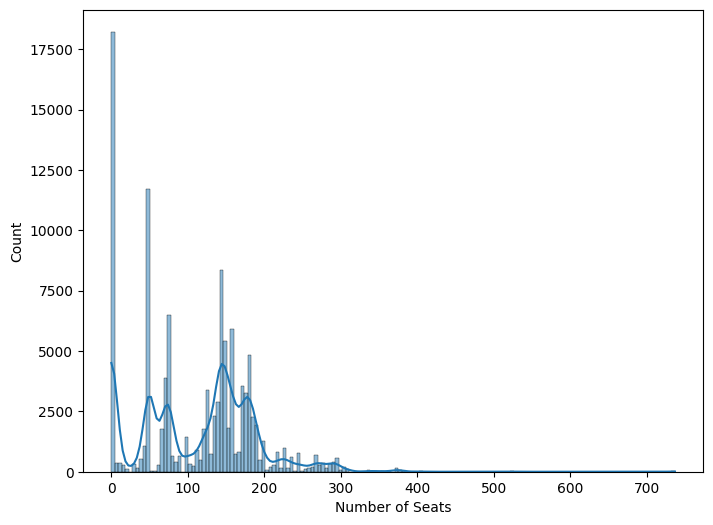

In [48]:
skewness_seats = data['NUMBER_OF_SEATS'].skew()
print(f"Skew: {skewness_seats}")

plt.figure(figsize=(8, 6))
sns.histplot(data['NUMBER_OF_SEATS'], kde=True)
plt.xlabel('Number of Seats')
plt.show()


Skew: 3.8593303829684253


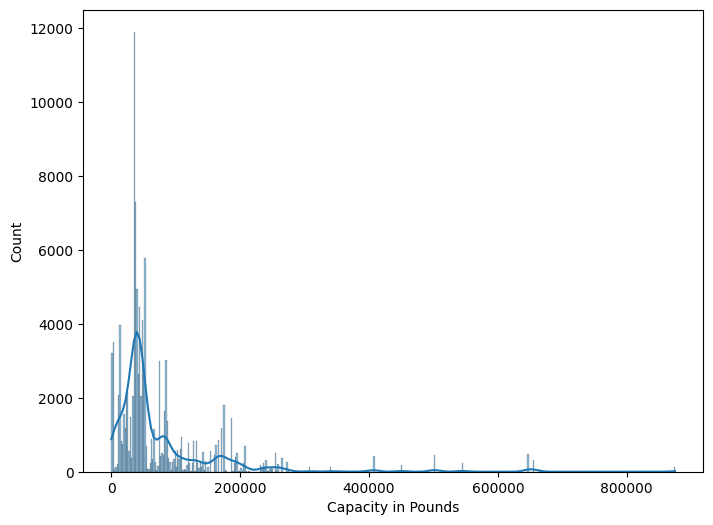

In [49]:
skewness_capacity = data['CAPACITY_IN_POUNDS'].skew()
print(f"Skew: {skewness_capacity}")

plt.figure(figsize=(8, 6))
sns.histplot(data['CAPACITY_IN_POUNDS'], kde=True)
plt.xlabel('Capacity in Pounds')
plt.show()


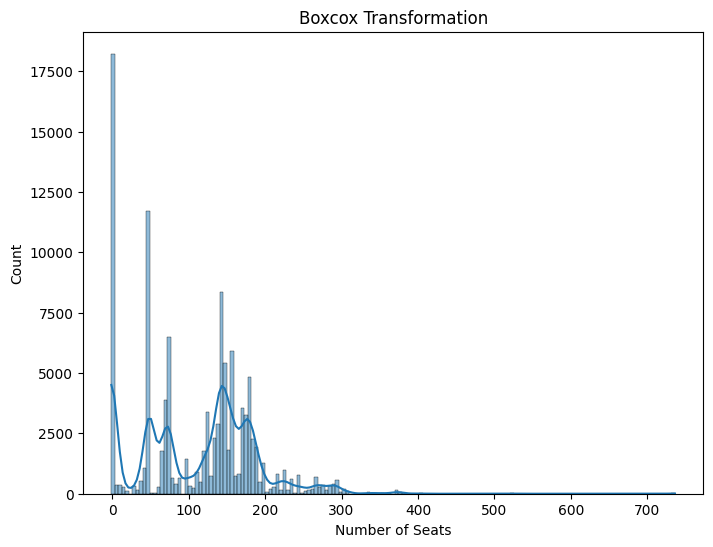

In [50]:
from scipy.stats import boxcox

data['NUMBER_OF_SEATS_BOXCOX'] = boxcox(data['NUMBER_OF_SEATS'].to_numpy(), lmbda=1)
# lmbda = 1 means no change in scaling

plt.figure(figsize=(8, 6))
sns.histplot(data['NUMBER_OF_SEATS_BOXCOX'], kde=True)
plt.title('Boxcox Transformation')
plt.xlabel('Number of Seats')
plt.show()


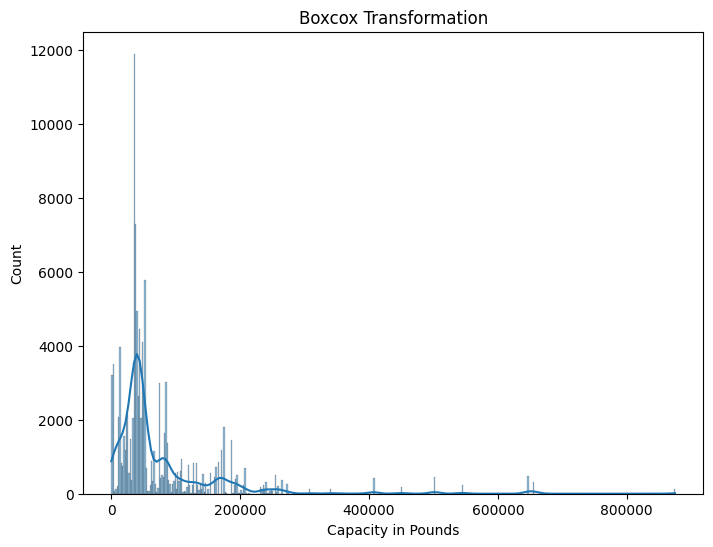

In [51]:
data['CAPACITY_IN_POUNDS_BOXCOX'] = boxcox(data['CAPACITY_IN_POUNDS'].to_numpy(), lmbda=1)

plt.figure(figsize=(8, 6))
sns.histplot(data['CAPACITY_IN_POUNDS_BOXCOX'], kde=True)
plt.title('Boxcox Transformation')
plt.xlabel('Capacity in Pounds')
plt.show()


# 5. Plane Sizes

In [52]:
quartiles = data['NUMBER_OF_SEATS'].quantile([0.25, 0.5, 0.75])

def size(seats):
  if seats < quartiles[0.25]:
    return 'SMALL'
  elif seats < quartiles[0.5]:
    return 'MEDIUM'
  elif seats < quartiles[0.75]:
    return 'LARGE'
  else:
    return 'XLARGE'

data['SIZE'] = data['NUMBER_OF_SEATS'].apply(size)

In [53]:
data['OPERATING_STATUS'] = data['OPERATING_STATUS'].str.replace('y', 'Y')
data['OPERATING_STATUS'] = data['OPERATING_STATUS'].str.replace(' ', 'Y')
# drop rows not Y or N
data = data[data['OPERATING_STATUS'].isin(['Y', 'N'])]
data['OPERATING_STATUS'].value_counts()

,count
OPERATING_STATUS,
Y,105862
N,4848


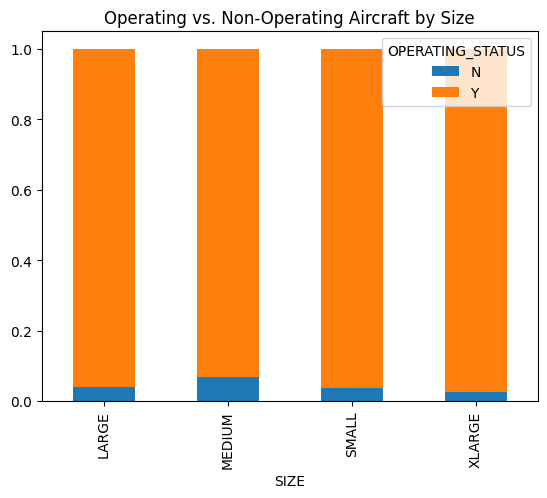

In [54]:
# (CAI) Group operating status proportions for each size group
operating_status_proportions = data.groupby('SIZE')['OPERATING_STATUS'].value_counts(normalize=True).unstack()
operating_status_proportions.plot(kind='bar', stacked=True)

plt.title('Operating vs. Non-Operating Aircraft by Size')
plt.show()


In [55]:
data['AIRCRAFT_STATUS'] = data['AIRCRAFT_STATUS'].str.upper()
data['AIRCRAFT_STATUS'].value_counts()

,count
AIRCRAFT_STATUS,
O,67741
B,34644
A,8203
L,122


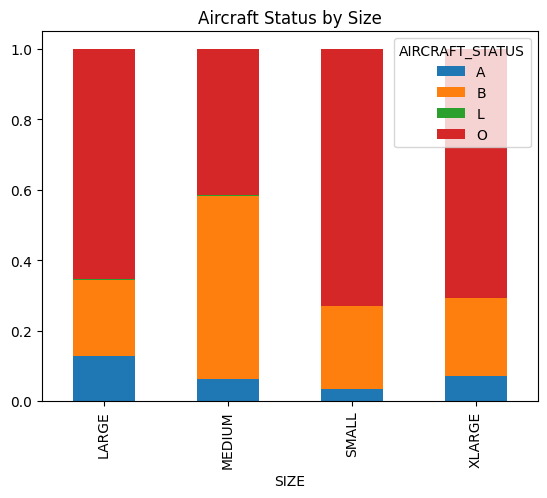

In [56]:
# (CAI) Group aircraft status proportions for each size group
aircraft_status_proportions = data.groupby('SIZE')['AIRCRAFT_STATUS'].value_counts(normalize=True).unstack()
aircraft_status_proportions.plot(kind='bar', stacked=True)
plt.title('Aircraft Status by Size')
plt.show()


In [57]:
operating_status_proportions

OPERATING_STATUS,N,Y
SIZE,,
LARGE,0.039335,0.960665
MEDIUM,0.067064,0.932936
SMALL,0.037275,0.962725
XLARGE,0.027011,0.972989


In [58]:
aircraft_status_proportions

AIRCRAFT_STATUS,A,B,L,O
SIZE,,,,
LARGE,0.127284,0.217574,0.001775,0.653367
MEDIUM,0.061650,0.521954,0.001022,0.415374
SMALL,0.034899,0.234181,NaN,0.730920
XLARGE,0.072063,0.220097,0.001410,0.706431
